<a href="https://colab.research.google.com/github/inhovation97/Get-an-education-Computer-Vision/blob/main/Image%20Segmentation/Unet_tutorial_origin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [ ]:
# Numpy N-dims Array X
# image, image -> 4D tensor --> Train 배치 사이즈 포함
# Image_generator
#  U-Net Input 2*n
def image_generator(files, batch_size = 32, sz = (256, 256)):

  while True: 
    
    # image file 중 32장을 랜덤하게 골라라
    # 32개의 index를 뽑아 줍니다. 
    batch = np.random.choice(files, size = batch_size) # 이미지 파일의 경로들을 배치단위로 뽑아오는 것

    # list for Image, Mask
    batch_x = []
    batch_y = []
    
    # batch -> list
    for f in batch:
        #get the masks. Note that masks are png files 
        # Image -> Random -> Read -> Resize (256, 256)
        # path = 'annotations/trimaps/{}.png'.format(f[:-4])
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png') # 경로를 뽑아왔으니 for문에서 PIL로 open해주는 것임 -> annotation 이미지가 안보이는 건 mask인 라벨 이미지인데 너무 작은 픽셀값이라 까맣게 보이는 것
        mask = np.array(mask.resize(sz)) # 읽은 이미지를 resize해서 np로 읽어 줌
        
        #preprocess the binary mask 
        mask[mask >= 2] = 0           # -> 0 or 1로 마스크를 처리해줌 (1,2,3의 값으로 채워져있는 것 같음 )
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}') 
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        # if GRAY (256, 256) --> Length of Tuple ? 2
        # elif Color (256, 256, 3) --> Length of Tuple ? 3
        #  GRAY ? Color

        if len(raw.shape) == 2: # gray 스케일이냐 or color냐? len==2이면, 256 256 흑백 스케일이니까
          raw = np.stack((raw,)*3, axis=-1) # 3장을 쌓아서 3채널을 만들어줌

        else:
          raw = raw[:,:,0:3] # 이건 걍 컬러 이미지

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. # numpy배열 & to tensor
    batch_y = np.array(batch_y)
    # (32, 256, 256)
    batch_y = np.expand_dims(batch_y,3) # batch_y = np.expand_dims(batch_y,-1) 이렇게 만들어준 것 굳이 끝에 1이라는 차원을 넣어줘야하나봄
    # (32, 256, 256, 1)

    yield (batch_x, batch_y) 
    
    # batch_x: 32, 256, 256, 3
    # batch_y: 32, 256, 256, 1 

In [ ]:
mask=Image.open(f'/content/images/Abyssinian_1.jpg') # )
mask = np.array(mask.resize((256,256)))

In [ ]:
batch_size = 32

all_files = os.listdir('images')
# get all files in images folder
# list 
shuffle(all_files) # 셔플

# len(all_files) -> N? 
# 0.95 -> training, 0.05 --> Validation
split = int(0.95 * len(all_files)) # train/test 스플릿

#split into training and testing
train_files = all_files[0:split] # 95프로 train
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [ ]:
x, y= next(train_generator)

In [ ]:
print (x.shape, y.shape)

(32, 256, 256, 3) (32, 256, 256, 1)


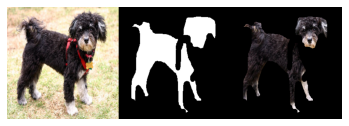

In [ ]:
plt.axis('off')
img = x[0]
# (256, 256, 3)
msk = y[0].squeeze()
# (256,256, 1) --> (256, 256)으로 해주는 것이 squeeze
# (256, 256)
msk = np.stack((msk,)*3, axis=-1) # 이미지는 3채널이 있으니 마스크도 3채널을 만들어준 뒤, 아래처럼 분류한 이미지를 만들어준 것 
# Image (256, 256, 3) * Mask (256, 256, 3)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [ ]:
# 교집합/합집합 -> 예측, 정답segmentation 영역의 합집합으로 겹치는 픽셀부분을 나눈 것임
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32') # binary로 했기 때문에 0.5 임계값
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou # loss func으로 쓰일 수 있다.

# Model

In [ ]:
def conv_block(x, nkernels):
  x = Conv2D(nkernels, (3,3), activation='relu', kernel_initializer ='he_normal', use_bias=False, padding='same') (x) # 
  x = BatchNormalization()(x)

In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  nkernels = 64 # 내맘
  # number of output feature 
  
  #layers = []
  # (32, 256, 256, 3)
  layer11 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (x)
  # layer11 : (32, 256, 256, 64)
  layer12 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (layer11)
  # (32, 256, 256, 64)
  layer13 = MaxPooling2D() (layer12)
  # (32, 128, 128, 64)

  layer21 = Conv2D(nkernels*2, (3,3), activation='relu', padding='same') (layer13)
  # (32, 128, 128, 128) 2배로 개수 늘려 줌
  layer22 = Conv2D(nkernels*2, (3,3), activation='relu', padding='same') (layer21)
  # (32, 128, 128, 128)
  layer23 = MaxPooling2D() (layer22)
  # (32, 64, 64, 128)

  layer31 = Conv2D(nkernels*4, (3,3), activation='relu', padding='same') (layer23)
  # (32, 64, 64, 256) 2배로 개수 늘려 줌
  layer32 = Conv2D(nkernels*4, (3,3), activation='relu', padding='same') (layer31)
  # (32, 64, 64, 256)
  layer33 = MaxPooling2D() (layer32)
  # (32, 32, 32, 256)

  layer41 = Conv2D(nkernels*8, (3,3), activation='relu', padding='same') (layer33)
  # (32, 32, 32, 512)
  layer42 = Conv2D(nkernels*8, (3,3), activation='relu', padding='same') (layer41)
  # (32, 32, 32, 512)
  layer43 = MaxPooling2D() (layer42)
  # (32, 16, 16, 512)

  layer51 = Conv2D(nkernels*16, (3,3), activation='relu', padding='same') (layer43)
  # (32, 16, 16, 1024)

# 여기서부터 반으로 줄이면서 upsampling
  layer52 = Conv2D(nkernels*8, (3,3), activation='relu', padding='same') (layer51)
  # (32, 16, 16, 512)

  layer61 = UpSampling2D()(layer52) # 이거는 nerest neighbor 보간으로 키우기만 함
  # (32, 32, 32, 512)
  layer62 = Concatenate(axis=3)([layer61, layer42]) # 여기서부터 concat이 이루어지는데, 42에서 나온 같은 사이즈의 fm을 concat해줌(skip connection)
  # (32, 32, 32, 1024)
  layer63 = Conv2D(nkernels*8, (3,3), activation='relu', padding='same') (layer62)
  # (32, 32, 32, 512)
  layer64 = Conv2D(nkernels*4, (3,3), activation='relu', padding='same') (layer63)
  # (32, 32, 32, 256)

  layer71 = UpSampling2D()(layer64) 
  # (32, 64, 64, 256)
  layer72 = Concatenate(axis=3)([layer71, layer32])
  # (32, 64, 64, 512)
  layer73 = Conv2D(nkernels*4, (3,3), activation='relu', padding='same') (layer72)
  # (32, 64, 64, 256)
  layer74 = Conv2D(nkernels*2, (3,3), activation='relu', padding='same') (layer73)
  # (32, 64, 64, 128)

  layer81 = UpSampling2D()(layer74)
  # (32, 128, 128, 128)
  layer82 = Concatenate(axis=3)([layer81, layer22])
  # (32, 128, 128, 256)
  layer83 = Conv2D(nkernels*2, (3,3), activation='relu', padding='same') (layer82)
  # (32, 128, 128, 128)
  layer84 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (layer83)
  # (32, 128, 128, 64)

  layer91 = UpSampling2D()(layer84)
  # (32, 256, 256, 64)
  layer92 = Concatenate(axis=3)([layer91, layer12])
  # (32, 256, 256, 128)
  layer93 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (layer92)
  # (32, 256, 256, 64)
  layer94 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (layer93)
  # (32, 256, 256, 64)

  outputs = Conv2D(1, (3,3), activation='sigmoid', padding='same') (layer94)
  # (32, 256, 256, 1)

  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou]) # sigmoid라서 이진 크로스엔트로피 이용
  
  return model

In [ ]:
model = unet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [ ]:
def build_callbacks(): # 한 eopch 이후 부를 함수 지정
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files) # test 파일중 하나 초이스
        raw = Image.open(f'images/{path}') # 그 이미지를 부름
        raw = np.array(raw.resize((256, 256)))/255. # 똑같이 정규화
        raw = raw[:,:,0:3] 
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze() # 마스크의 쓸데없는 채널을 스퀴즈로 날려줌
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 # 마스크가 선형이기에 임계값 넣어주기
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training


i= 1 loss= 168.67732532819113 val_loss= 0.6094341278076172 mean_iou= 0.0029744327 val_mean_iou= 0.0


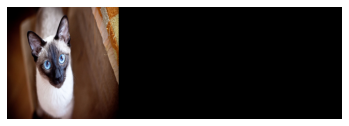

i= 2 loss= 0.5954893568879394 val_loss= 0.5553220510482788 mean_iou= 0.0005906189 val_mean_iou= 0.0


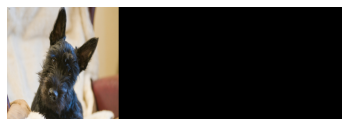

i= 3 loss= 0.7254148574724589 val_loss= 0.49565714597702026 mean_iou= 0.12135093 val_mean_iou= 0.47737690806388855


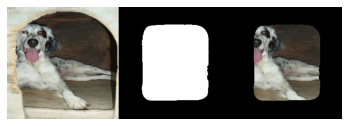

i= 4 loss= 0.454831405861737 val_loss= 0.36957165598869324 mean_iou= 0.4227672 val_mean_iou= 0.4595930874347687


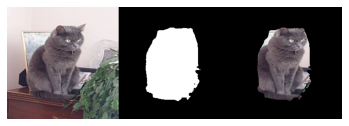

i= 5 loss= 0.4334678504292823 val_loss= 0.4242343306541443 mean_iou= 0.4583311 val_mean_iou= 0.49183881282806396


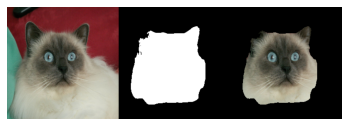

i= 6 loss= 0.41952634061852545 val_loss= 0.5518894195556641 mean_iou= 0.47132343 val_mean_iou= 0.2118411511182785


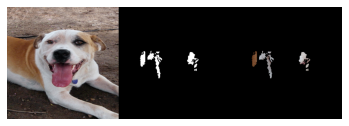

i= 7 loss= 0.3857078339955578 val_loss= 0.3641507029533386 mean_iou= 0.52066433 val_mean_iou= 0.5653412342071533


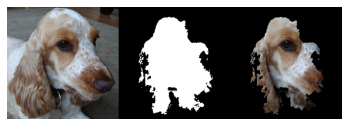

i= 8 loss= 0.350673230339403 val_loss= 0.3189748525619507 mean_iou= 0.5755342 val_mean_iou= 0.6467009782791138


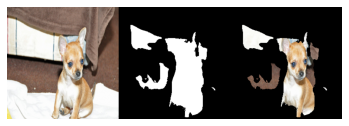

i= 9 loss= 0.3219711974467317 val_loss= 0.2975444197654724 mean_iou= 0.60914457 val_mean_iou= 0.6354649066925049


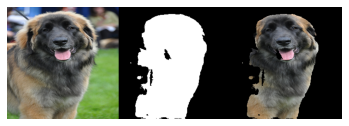

i= 10 loss= 0.2961083615207237 val_loss= 0.30676496028900146 mean_iou= 0.65035105 val_mean_iou= 0.6496009230613708


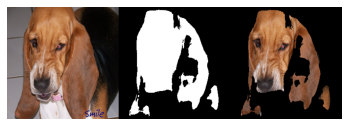

i= 11 loss= 0.27607084007840177 val_loss= 0.252653032541275 mean_iou= 0.67379624 val_mean_iou= 0.6963997483253479


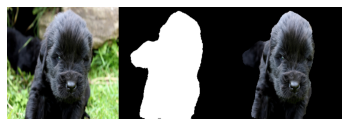

i= 12 loss= 0.24533934101938656 val_loss= 0.24800722301006317 mean_iou= 0.7054545 val_mean_iou= 0.6995458602905273


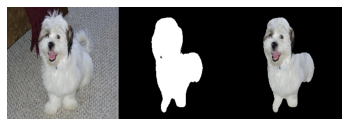

i= 13 loss= 0.23394031781856328 val_loss= 0.251046359539032 mean_iou= 0.72436225 val_mean_iou= 0.7484683394432068


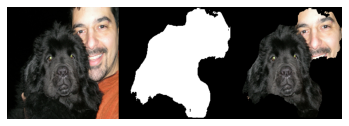

i= 14 loss= 0.22354383514896375 val_loss= 0.2516804039478302 mean_iou= 0.7360687 val_mean_iou= 0.7197258472442627


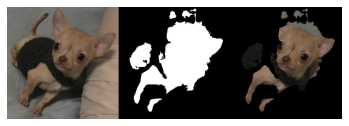

i= 15 loss= 0.2120233216242159 val_loss= 0.20383524894714355 mean_iou= 0.7486522 val_mean_iou= 0.7519029974937439


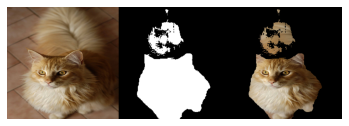

i= 16 loss= 0.19786595236765195 val_loss= 0.24060994386672974 mean_iou= 0.76412755 val_mean_iou= 0.7055184841156006


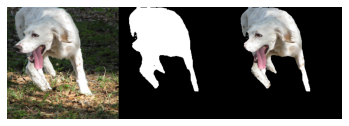

i= 17 loss= 0.18736448118539706 val_loss= 0.1669035255908966 mean_iou= 0.7754986 val_mean_iou= 0.7695476412773132


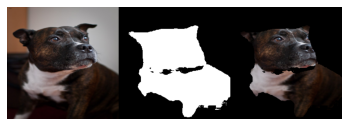

i= 18 loss= 0.18418252985227054 val_loss= 0.2959508001804352 mean_iou= 0.78703177 val_mean_iou= 0.6353108882904053


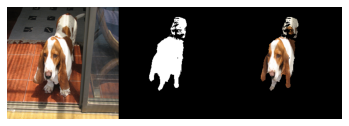

i= 19 loss= 0.17713028900155195 val_loss= 0.25070899724960327 mean_iou= 0.79026294 val_mean_iou= 0.7338280081748962


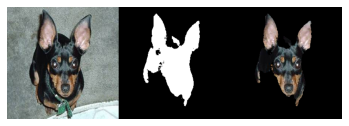

i= 20 loss= 0.16856143072451632 val_loss= 0.19197553396224976 mean_iou= 0.7994389 val_mean_iou= 0.7839141488075256


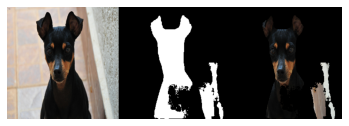

i= 21 loss= 0.15881459772178572 val_loss= 0.34752726554870605 mean_iou= 0.80708975 val_mean_iou= 0.7629520893096924


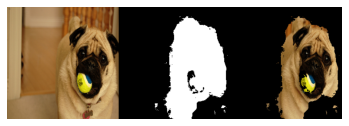

i= 22 loss= 0.15354146910448596 val_loss= 0.2439645230770111 mean_iou= 0.8161818 val_mean_iou= 0.7744624614715576


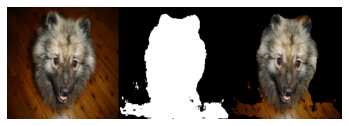

i= 23 loss= 0.14896638327401523 val_loss= 0.35141390562057495 mean_iou= 0.82131386 val_mean_iou= 0.6953121423721313


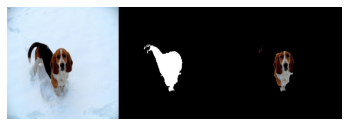

i= 24 loss= 0.14418504131983403 val_loss= 0.2473372220993042 mean_iou= 0.826044 val_mean_iou= 0.758388876914978


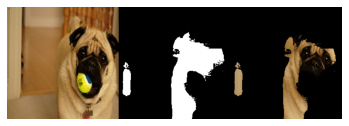

i= 25 loss= 0.14149458614522464 val_loss= 0.2042493373155594 mean_iou= 0.8319854 val_mean_iou= 0.7864280343055725


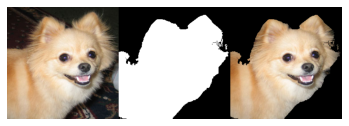

i= 26 loss= 0.1387244215975069 val_loss= 0.18480798602104187 mean_iou= 0.83337116 val_mean_iou= 0.770284116268158


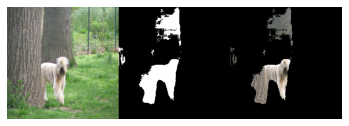

i= 27 loss= 0.14044595363477594 val_loss= 0.29128924012184143 mean_iou= 0.83198315 val_mean_iou= 0.7853862643241882


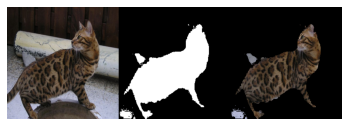

i= 28 loss= 0.1335250788695736 val_loss= 0.19351041316986084 mean_iou= 0.83813614 val_mean_iou= 0.7684698104858398


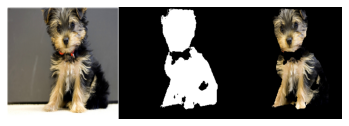

i= 29 loss= 0.13232211363778268 val_loss= 0.26163890957832336 mean_iou= 0.8404525 val_mean_iou= 0.7839508652687073


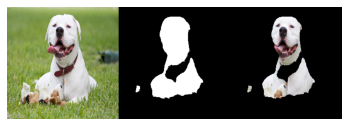

i= 30 loss= 0.13607845383964173 val_loss= 0.22170084714889526 mean_iou= 0.8362817 val_mean_iou= 0.7712175250053406


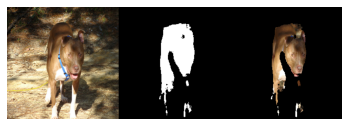

In [ ]:
train_steps = len(train_files) //batch_size # iteration
test_steps = len(test_files) //batch_size 
model.fit_generator(train_generator, #
                    epochs = 30, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [ ]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

In [ ]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

